<h1><center> Building Recommender Systems: Latest MovieLens Dataset (small 100k) </center></h1>
<h2><center> Southern Methodist University: Masters of Data Science </center></h2>
<h3><center> MSDS 7331: Data Mining - Lab 3 </center></h3>
<h4><center> Jethin Abraham, Laurie Harris, Daniel Higdon, Jack Nelson </center></h4>

In [1]:
import zipfile
import os
from urllib import urlretrieve
import graphlab as gl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns

reload(sys)  
sys.setdefaultencoding('utf8')

This non-commercial license of GraphLab Create for academic use is assigned to nelsonjohn@mail.smu.edu and will expire on December 02, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1512525130.log


<h2> Business Understanding 1 </h2>  
Describe the purpose of the data set you selected (i.e. why was this data collected in the first place?).  How will you measure the effectiveness of a good algorithm?  Why does your chosen validation method make sense for the specific dataset and the stakeholders needs?

<h2> Data Understanding 1 </h2>  
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.  Verify data quality: Are there missing values?  Duplicate data?  Outliers?  Are those mistakes?  How do you deal with these problems.

<h4> Reading in Files </h4>  
The MovieLens dataset is actually a collection of 4 comma separated values (csv) files that can you joined with certain ID fields.  This prevents unecessary duplicate data values for storage, similar to how relational databases are designed.  We begin by downloading the zip file from the url provided at https://grouplens.org/datasets/movielens/, opening the downloaded function, and extracting the contents.  A conditional was added for optimization if previously downloaded.  

In [2]:
#downloading MovieLens Latest Datasets-Small from https://grouplens.org/datasets/movielens/
if os.path.isdir('ml-latest-small/'):
    print 'MovieLens dataset already extracted and saved on local machine'
else:
    urlretrieve('http://files.grouplens.org/datasets/movielens/ml-latest-small.zip','ml-latest-small.zip')
    zfile = zipfile.ZipFile('ml-latest-small.zip')
    zfile.extractall()
    os.remove('ml-latest-small.zip')

<h4> Data Description and Meaning </h4>  
The contents of the zip file is a folder titled 'ml-latest-small' with four csv files inside: 'movies.csv', 'ratings.csv', 'tags.csv', and 'links.csv'.  The four files can be joined together using the following identification fields:
 - **userId**: <u>Type</u>: string, <u>Description</u>: unique MovieLens users that selected at random from the full set and anonymized.  The field can be used to link 'ratings.csv' and 'tags.csv'
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique movies with at least one rating in the dataset.  The field can be used to link 'ratings.csv', 'tags.csv', 'movies.csv', and 'links.csv'  
 
A description of each csv file and fields are as follows:  
  
<i><u>movies.csv</u></i>  
csv file of movies and their genres   
 - **movidId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie  
 - **title**: <u>Type</u>: string, <u>Description</u>: textual title of of a movie  
 - **genres**: <u>Type</u>: list, <Description</u>: pipe-separated list for genre(s) describing a movie
     - 18 genres possible values to select from {Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western}
     - Not every movie lists a genre  
     
<i><u>ratings.csv</u></i>  
csv file of ratings for movies by MovieLens users   
 - **userId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a MovieLens user  
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie  
 - **rating**: <u>Type</u>: float, <u>Description</u>: rating given to a movie by MovieLens user on a 5-star scale with half-star increments  
 - **timestamp**: <u>Type</u>: int, <u>Description</u>: timestamp of rating represented as seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970  
  
<i><u>tags.csv</u></i>  
csv file of tags for movies chosen by MovieLens users  
 - **userId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a MovieLens user  
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie  
 - **tag**: <u>Type</u>: string, <u>Description</u>: a word or short phrase generated by a MovieLens user for a particular movie whose meaning user-specific  
  
<i><u>links.csv</u></i>  
csv file to link movie information from other movie databases  
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie
 - **imdbId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie used by http://www.imdb.com  
 - **tmdbId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie used by http://www.themoviedb.org  

<h4> Verify Data Quality </h4>  

Now that we understand the dataset files as well as the type and meaning of each attribute.  Let's load each csv file into a GraphLab SFrame and view its output in the Canvas.  <u><i>Links.csv</i></u> will not be loaded since we are not using imdb or tmdb in this notebook.  
  
<h4><u><i>movies.csv</i></u></h4>  

In [3]:
movies_sf = gl.SFrame.read_csv('ml-latest-small/movies.csv', column_type_hints={'movieId':str})
movies_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies.csv

Parsing completed. Parsed 100 lines in 0.16166 secs.

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies.csv

Parsing completed. Parsed 9125 lines in 0.024275 secs.

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...
2,Jumanji (1995),Adventure|Children|Fantasy ...
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride PartII (1995) ...,Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
movies_sf.show()

![title](screenshots/movies_sf.png)  
*Screenshot from GraphLab Canvas window*

Note that the pipe-separated list for the **genres** attribute did not read in as a list, but a string.  This is because the csv file is not in a format for GraphLab to recognize a list (current format: 'genre1|genre2|genre3', desired format: '[genre1, genre2, genre3]').  Since no clean way to make this conversion was identified in GraphLab, we will utilize pandas and the split function.  A new csv file, 'movies2.csv', is saved for GraphLab to read in.  The original pipe-separated list is kept in the new csv file as there may be benefit to recommending movies with the exact same set of genres.     

In [5]:
temp = pd.read_csv('ml-latest-small/movies.csv')

genre_list = [0]*len(temp['genres'])

for i in range(len(temp['genres'])):
    genre_list[i] = temp['genres'][i].split('|')
    
temp['genre_list'] = genre_list
temp.to_csv('ml-latest-small/movies2.csv')

The new csv file loaded over the existing GraphLab SFrame and viewed on the Canvas.

In [6]:
movies_sf = gl.SFrame.read_csv('ml-latest-small/movies2.csv', column_type_hints={'movieId':str}).remove_column('X1')
movies_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies2.csv

Parsing completed. Parsed 100 lines in 0.099341 secs.

These column type hints were not used: X1

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies2.csv

Parsing completed. Parsed 9125 lines in 0.054147 secs.

movieId,title,genres,genre_list
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...,"[Adventure, Animation,Children, Comedy, ..."
2,Jumanji (1995),Adventure|Children|Fantasy ...,"[Adventure, Children,Fantasy] ..."
3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
5,Father of the Bride PartII (1995) ...,Comedy,[Comedy]
6,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]"
7,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"
8,Tom and Huck (1995),Adventure|Children,"[Adventure, Children]"
9,Sudden Death (1995),Action,[Action]
10,GoldenEye (1995),Action|Adventure|Thriller,"[Action, Adventure,Thriller] ..."


In [7]:
movies_sf.show()

![title](screenshots/movies_sf_genrelist.png)  
*Screenshot from GraphLab Canvas window*

Now that the movie genres are properly classified as a list, we check to make sure there are no duplicates in the movieId field.  Each line should represent an independent movie to ensure no unecessary duplicates will be created when we join it with other SFrames.  We will investigate using a user-defined function GetDuplicates for simplicity.

In [8]:
def GetDuplicates(sf,name):
    dup = sf.groupby([name], gl.aggregate.COUNT(name))
    return(dup[dup['Count'] > 1])

In [9]:
GetDuplicates(movies_sf,'movieId')

movieId,Count


We can see there are no duplicate movieId values from the output.  Consequently, we will check to see if there are any duplicate movie titles for the same reason.

In [10]:
GetDuplicates(movies_sf,'title')

title,Count
Hamlet (2000),2
War of the Worlds (2005),2


We find that there are two duplicate movie titles.  This isn't uncommon if a relatively older movie was remade recently.  However, this is unlikely the case since the movie title field contains the year the movie was released.  Therefore, duplicates with the same title and year release will be assumed to be the same movie.  This SFrame as well as other subsequent SFrames with a movieId field will need to be recoded for one of the two movieId.  We will look at the genres for each movie to see which movieId to use. 

In [11]:
dup_titles = ['Hamlet (2000)', 'War of the Worlds (2005)']
movies_sf.filter_by(dup_titles, 'title')

movieId,title,genres,genre_list
3598,Hamlet (2000),Crime|Drama|Romance|Thriller ...,"[Crime, Drama, Romance,Thriller] ..."
34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller ...,"[Action, Adventure, Sci-Fi, Thriller] ..."
64997,War of the Worlds (2005),Action|Sci-Fi,"[Action, Sci-Fi]"
65665,Hamlet (2000),Drama,[Drama]


movieId 3598 for 'Hamlet (2000)' and 34048 for 'War of the Worlds (2005)' contain more genres than their counterparts, so we will use those as they may provide more information.  In total, there will be 9,123 movies in this dataset after cleaning.

In [12]:
dup_Ids = ['64997','65665']
movies_sf = movies_sf.filter_by(dup_Ids, 'movieId', exclude=True)
movies_sf

movieId,title,genres,genre_list
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...,"[Adventure, Animation,Children, Comedy, ..."
2,Jumanji (1995),Adventure|Children|Fantasy ...,"[Adventure, Children,Fantasy] ..."
3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
5,Father of the Bride PartII (1995) ...,Comedy,[Comedy]
6,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]"
7,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"
8,Tom and Huck (1995),Adventure|Children,"[Adventure, Children]"
9,Sudden Death (1995),Action,[Action]
10,GoldenEye (1995),Action|Adventure|Thriller,"[Action, Adventure,Thriller] ..."


In [13]:
movies_sf.show()

![title](screenshots/movies_sf_clean.png)  
*Screenshot from GraphLab Canvas window*

<h4><u><i>ratings.csv</i></u></h4>

In [14]:
ratings_sf = gl.SFrame.read_csv('ml-latest-small/ratings.csv', column_type_hints={'movieId':str,'userId':str})

#convert timestamp seconds value to a user-readable datetime format
ratings_sf['timestamp'] = ratings_sf['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
#movieId duplicate title fix
ratings_sf['movieId'].apply(lambda x: '3598' if x == '65665' else x)
ratings_sf['movieId'].apply(lambda x: '34048' if x == '64997' else x)

ratings_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/ratings.csv

Parsing completed. Parsed 100 lines in 0.160727 secs.

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/ratings.csv

Parsing completed. Parsed 100004 lines in 0.105513 secs.

userId,movieId,rating,timestamp
1,31,2.5,2009-12-13 21:52:24
1,1029,3.0,2009-12-13 21:52:59
1,1061,3.0,2009-12-13 21:53:02
1,1129,2.0,2009-12-13 21:53:05
1,1172,4.0,2009-12-13 21:53:25
1,1263,2.0,2009-12-13 21:52:31
1,1287,2.0,2009-12-13 21:53:07
1,1293,2.0,2009-12-13 21:52:28
1,1339,3.5,2009-12-13 21:52:05
1,1343,2.0,2009-12-13 21:52:11


In [15]:
ratings_sf.show()

![title](screenshots/ratings_sf.png)  
*Screenshot from GraphLab Canvas window*

We see from the Canvas output that each data type was read in correctly and there are no missing/undefined values.  Also note that users can rate multiple movies and movies can be rated by multiple users so there is no need to check for duplicates.

<h4><u><i>tags.csv</i></u></h4>

In [16]:
tags_sf = gl.SFrame.read_csv('ml-latest-small/tags.csv', column_type_hints={'movieId':str,'userId':str})

#convert timestamp seconds value to a user-readable datetime format
tags_sf['timestamp'] = tags_sf['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
#movieId duplicate title fix
tags_sf['movieId'].apply(lambda x: '3598' if x == '65665' else x)
tags_sf['movieId'].apply(lambda x: '34048' if x == '64997' else x)

tags_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/tags.csv

Parsing completed. Parsed 100 lines in 0.052707 secs.

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/tags.csv

Parsing completed. Parsed 1296 lines in 0.011543 secs.

userId,movieId,tag,timestamp
15,339,sandra 'boring' bullock,2006-01-29 07:29:30
15,1955,dentist,2007-10-26 17:44:21
15,7478,Cambodia,2007-02-03 22:49:57
15,32892,Russian,2007-02-04 16:59:26
15,34162,forgettable,2006-03-03 08:16:05
15,35957,short,2006-03-03 08:17:53
15,37729,dull story,2006-03-03 08:16:46
15,45950,powerpoint,2007-01-24 00:24:51
15,100365,activist,2015-03-09 00:43:40
15,100365,documentary,2015-03-09 00:43:40


In [17]:
tags_sf.show()

![title](screenshots/tags_sf.png)  
*Screenshot from GraphLab Canvas window*

Just as in <u><i>ratings.csv</i></u>, we see from the Canvas output that each data type was read in correctly and there are no missing/undefined values.  Again, note that users can tag multiple movies and movies can be tagged by multiple users so there is no need to check for duplicates.

<h2> Data Understanding 2 </h2>  
Visualize any important attributes appropriately.  Important: Provide an interpretation for any charts or graphs.

<h3> Simple Statistics </h3>

We can see some simple statistics for attributes in the Canvas.  For instance, in <u><i>movies.csv</i></u>, the most frequent items for both **genres** and **genre_list** are *Drama* and *Comedy*.  They appear to separate themselves from the rest of the group by a reasonable margin.  

Furthermore, in <u><i>ratings.csv</i></u>, **ratings** range from 0.5 to 5.0 with a mean rating of approximately 3.5 and a median of 4.0 suggesting that ratings are skewed to the left.  The histogram in the Canvas (see below)  shows a small number of ratings on the low extreme shifting the mean.  A power user within MovieLens is also identified in **userId**, userId *547* has provided about 2.4% of the ratings, roughly 500 ratings than anyone else in the dataset.  
  
![title](screenshots/histogram_Value of rating.png) 
  
Consistent with <u><i>ratings.csv</i></u>, the same power user, **userId** *547*, is identified in the canvas for <u><i>tags.csv</i></u>.  However, the margin between for which this userId provides **tags** than anyone else is significantly wider.  userId *547* contributes approximately 30% of all tags in the dataset, 200 more than the next highest contributor.  The last noteworthy item from simple statistics in <u><i>tags.csv</i></u> is from **movieId**.  movieId *260* appears to be tagged more than any other movieId by a reasonable margin but upon further investigation, it only contains 9 more tags than the next movieId.

<h3> Top Rated and Popular Attributes </h3>  
  
Before we delve into finding highly rated movies by popularity for certain attributes, ploting functions are created for visualizations.  **HorzBarChart()** will create a horizontal bar chart two columns in a SFrame.  And **RatingStripPlot()** will create a strip plot for ratings separated by a attribute in the ratings SFrame.  Jittering is added on both axes to view the spread of values are not continuous.

In [26]:
def HorzBarChart(x, y, x_label, plot_title):
    y_pos = np.arange(len(y))
    plt.barh(y_pos, x)
    plt.yticks(y_pos, y)
    plt.xlabel(x_label)
    plt.title(plot_title)
    plt.show()
    
def RatingStripPlot(sf, y_axis_field, plot_title, plot_order=None):
    sf['rating_jitter'] = sf['rating'].apply(lambda x: x + np.random.uniform(-0.25,0.25))
    ax = sns.stripplot(x='rating_jitter', y=y_axis_field, data=sf.to_dataframe(), order=plot_order, jitter=True)
    ax.set(xlabel='Rating', ylabel='', title=plot_title)
    plt.show()

<h4> Top Rated Movies </h4>  

To get the ratings for the top rated movies, the following steps are taken:
- An SFrame, **average_rating**, with an average rating and count of ratings by **movieId** using **groupby()** is generated.  
  
- It is then joined with **movies_sf** by **movieId** to get the readable title for that movie.  To avoid outliers where a movie only has a handful of ratings but the average rating is screwed by one or two high ratings, the **average_rating** SFrame is filtered for movies with more than 50 ratings before the top 10 movies are chosen with **topk()**. The result is saved as **top_rated**.   

- **top_rated** is joined back with **ratings_sf** to get all the ratings for the top 10 movies with more than 50 ratings.  It is saved as **top_ratings** for plotting with **RatingStripPlot()**.   

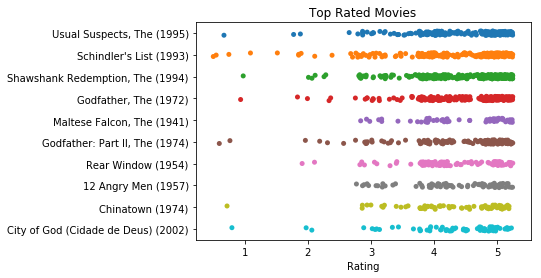

In [22]:
average_rating = ratings_sf.groupby(key_columns='movieId', operations={'avg_rating': gl.aggregate.MEAN('rating'),
                                                                       'count': gl.aggregate.COUNT()})

top_rated = average_rating[(average_rating['count'] > 50)].join(movies_sf['movieId','title']).topk('avg_rating')

top_ratings = top_rated.join(ratings_sf['movieId','rating'])
RatingStripPlot(top_ratings, 'title', 'Top Rated Movies',)

It appears the 70' and '90s were good decades for cinema.  Both produced 3 movies in the top ten.  In addition, The Godfather series has its first 2 movies in the top 6 movies.  As interesting as this plot is, not much inference can be drawn.  All we know with the plot is that MovieLens users liked these relatively popular movies.  Lets move forward by filtering based on various attributes to gain a better understanding of the data.   

<h4> Most Rated Movies </h4>  

To begin, we look at ratings based on popularity by following a similar process listed above when we were finding the ratings for the top 10 movies with the highest average rating.  The key differences in the process are as follows:  
- **average_rating** is not created and we use **count** to find the top 10 movies with the most ratings.
- **top_rated** is sorted to order movies when the **HorzBarChart()** function is used to plot the top 10 most rated movies.
- The **order** option is used in **RatingStripPlot()** to view movie ratings in the same order as the horizontal bar plot. 

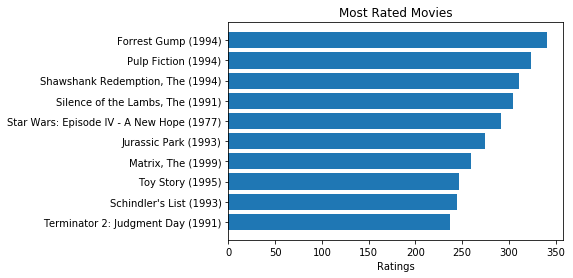

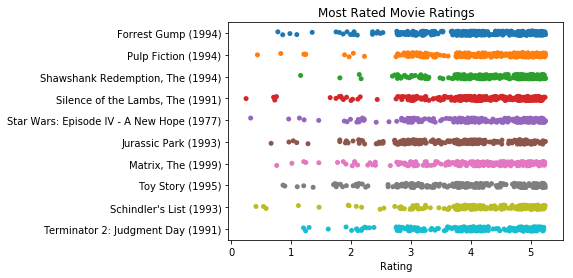

In [36]:
movie_rating_count = ratings_sf.groupby(key_columns='movieId', operations={'count': gl.aggregate.COUNT()})

most_rated = movie_rating_count.join(movies_sf['movieId','title']).topk('count').sort('count')

HorzBarChart(most_rated['count'], most_rated['title'], 'Ratings', 'Most Rated Movies')

most_rated_ratings = most_rated.join(ratings_sf['movieId','rating'])
RatingStripPlot(most_rated_ratings, 'title', 'Most Rated Movie Ratings', 
                list(most_rated.sort('count',ascending=False)['title']))

Based on popularity, it can be surmised that during the entire implementation of MovieLens, its hayday with the most number of active users rating movies was a period during or shortly after the early 90s.  9 out of 10 of the top rated movies were released in the 90s.  More specificially, 8 of the 9 released in a period from 1991-1995.  The validity of this hypothesis will be further investigated during the use of the **timestamp** attribute within <u><i>ratings.csv</i></u>.

Most Tagged Movies

In [115]:
movie_tag_count = tags_sf.groupby(key_columns='movieId', operations={'count': gl.aggregate.COUNT()})
top_tagged = movie_tag_count.join(movies_sf['movieId','title']).topk('count').sort('count')

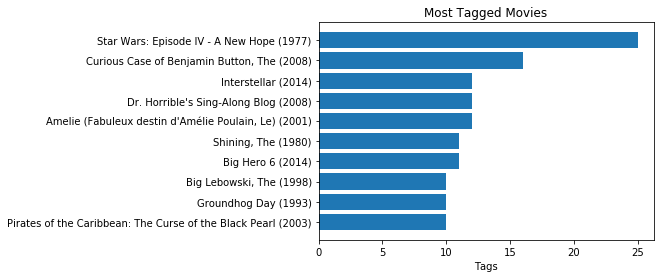

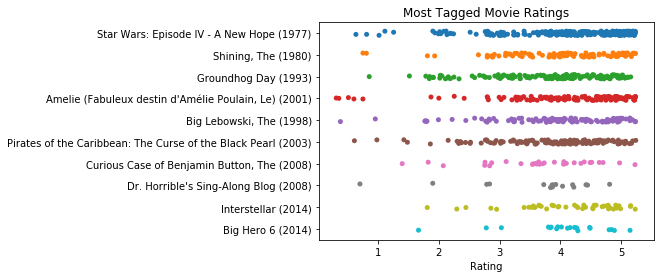

In [118]:
HorzBarChart(top_tagged['count'], top_tagged['title'], 'Tags', 'Most Tagged Movies')

top_tagged_ratings = top_tagged.join(ratings_sf['movieId','rating'])
RatingStripPlot(top_tagged_ratings, 'title', 'Most Tagged Movie Ratings', order = list(top_tagged['title']))

Genres

In [49]:
stacked_movies = movies_sf['movieId','title','genre_list'].stack('genre_list', new_column_name='genre')
genre_tag_count = movie_tag_count.join(stacked_movies['movieId','genre'])
genre_tag_count = genre_tag_count.groupby(key_columns='genre', operations={'count': gl.aggregate.COUNT()}).sort('count')
genre_tag_count.sort('count',ascending=False)

genre,count
Drama,403
Comedy,186
Thriller,164
Action,126
Romance,114
Crime,110
Adventure,103
Sci-Fi,73
Fantasy,57
Mystery,50


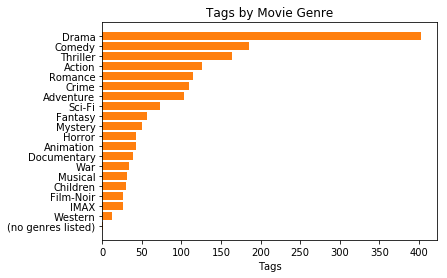

In [51]:
y_pos = np.arange(len(genre_tag_count['genre']))
plt.barh(y_pos, genre_tag_count['count'])
plt.yticks(y_pos, genre_tag_count['genre'])
plt.xlabel('Tags')
plt.title('Tags by Movie Genre')
 
plt.show()

In [52]:
genre_rating_count = movie_rating_count.join(stacked_movies['movieId','genre'])
genre_rating_count = genre_rating_count.groupby(key_columns='genre', operations={'count': gl.aggregate.COUNT()}).sort('count')
genre_rating_count.sort('count',ascending=False)

genre,count
Drama,4327
Comedy,3307
Thriller,1717
Action,1542
Romance,1541
Adventure,1116
Crime,1092
Horror,872
Sci-Fi,790
Fantasy,653


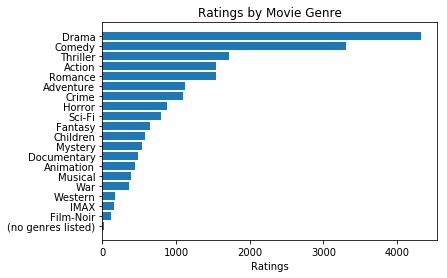

In [53]:
y_pos = np.arange(len(genre_rating_count['genre']))
plt.barh(y_pos, genre_rating_count['count'])
plt.yticks(y_pos, genre_rating_count['genre'])
plt.xlabel('Ratings')
plt.title('Ratings by Movie Genre')
 
plt.show()

In [180]:
tags_year = tags_sf.split_datetime('timestamp',limit=['year','month']
                                     ).groupby(key_columns='timestamp.year', 
                                               operations={'count': gl.aggregate.COUNT()}
                                              ).sort(['timestamp.year'])

tags_month = tags_sf.split_datetime('timestamp',limit=['year','month']
                                     ).groupby(key_columns=['timestamp.year','timestamp.month'], 
                                               operations={'count': gl.aggregate.COUNT()}
                                              ).sort(['timestamp.year','timestamp.month'])
tags_month['MonthYear'] = tags_month['timestamp.month'].apply(str)+'-'+tags_month['timestamp.year'].apply(str)

ratings_year = ratings_sf.split_datetime('timestamp',limit=['year','month']
                                     ).groupby(key_columns='timestamp.year', 
                                               operations={'count': gl.aggregate.COUNT()}
                                              ).sort(['timestamp.year'])

ratings_month = ratings_sf.split_datetime('timestamp',limit=['year','month']
                                     ).groupby(key_columns=['timestamp.year','timestamp.month'], 
                                               operations={'count': gl.aggregate.COUNT()}
                                              ).sort(['timestamp.year','timestamp.month'])
ratings_month['MonthYear'] = ratings_month['timestamp.month'].apply(str)+'-'+ratings_month['timestamp.year'].apply(str)

In [182]:
def TagsRatingsTimeSeries(ratings_x, ratings_y, tags_x, tags_y, x_label, plot_title):
    f, ax1 = plt.subplots(figsize=(20,5))
    ax1.plot(ratings_x, ratings_y, 'b')
    ax2 = ax1.twinx()
    ax2.plot(tags_x, tags_y, 'g')
    ax1.set(xlabel = x_label, ylabel = 'Number of Ratings')
    ax2.set(ylabel = 'Number of Tags', title = plot_title)
    plt.show()

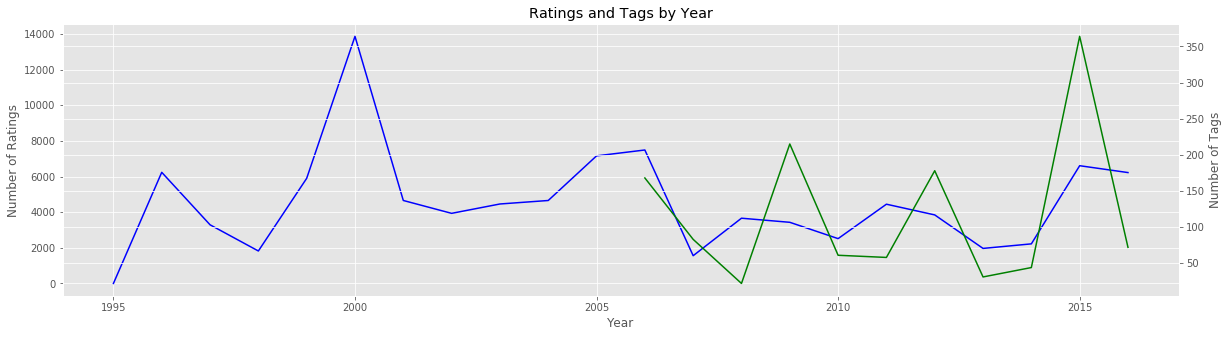

In [183]:
TagsRatingsTimeSeries(ratings_year['timestamp.year'], ratings_year['count'], 
                      tags_year['timestamp.year'], tags_year['count'], 
                      'Year', 'Ratings and Tags by Year')

<h2> Modeling and Evaluation 1 </h2>  
Train and adjust parameters.

<h2> Modeling and Evaluation 2 </h2>  
Evaluate and compare.

<h2> Modeling and Evaluation 3 </h2>  
Visualize results.

<h2> Modeling and Evaluation 4 </h2>  
Summarize the ramifications.

<h2> Deployment </h2>  
Be critical of your performance and tell the reader how your current model might be usable by other parties.  Did you achieve your goals?  If not, can you reign in the utility of you modeling?  How useful is your model for interested parties (i.e. the companies or organizations that might want to use it)?  How would you you deploy your model to interested parties.  What other data should be collected?  How often would the model need to be updated, etc?

<h2> Exceptional Work </h2>  
You have free reign to provide additional analyses or combine analyses

<h4> Resources </h4>  

*MovieLens Dataset*  
<sup>[1]</sup> F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.dio.org/10.1145/2827872  
  
*GraphLab API Documentation*  
<sup>[2]</sup> Turi. 2016. GraphLab Create API Documentation. https://turi.com/products/create/docs  
<sup>[3]</sup> Turi. 2016. Turi Machine Learning Platform User Guide. https://turi.com/learn/userguide/index.html  
  
*MSDS 7331: DataMiningNotebooks*  
<sup>[4]</sup> Eric Larson. 13. Recommendation Systems.ipynb. (2017) Southern Methodist University. https://github.com/elarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb 